In [1]:
using DataFrames


In [2]:
using IterativeSolvers
using Plots
using MatrixMarket

In [3]:
function  prolongation1(n)
    r = floor(Int, n/2) 
    R = zeros(r,n)
    i = 1
    j = 1
    while i ≤ r 
        R[i,j] = 1
        i = i + 1
        j = j + 2
    end
    return R
end

prolongation1 (generic function with 1 method)

In [4]:
function  prolongation2(n)
    r = floor(Int, n/2)
    R = zeros(r,n)
    i = 1
    j = 1
    while i ≤ r 
        R[i,j] = 1
        if(j+1 ≤ n)
            R[i,j+1] = 2
        end
        if(j+2 ≤ n)
            R[i,j+2] = 1
        end
        i = i + 1
        j = j + 2
    end
    return 1/4*R
end

prolongation2 (generic function with 1 method)

In [5]:
function computeTauI(A, F, i)
    aij = 0
    for j ∈ F
        aij = aij + abs(A[i,j])
    end
    
    if(isempty(F))
        return abs(A[i,i])
    end
    
    return abs(A[i,i]) / aij
end

computeTauI (generic function with 1 method)

In [6]:
function Adj(A, j, n)
    Adj = Set()
    for k = 1:n
        if(A[j,k] != 0)
            push!(Adj,k)
        end
    end
    return Adj
end

Adj (generic function with 1 method)

In [7]:
function greedyCoarsing(A)
    tau = 1
    
    n = size(A,1)
    U = Set(collect(1:n))
    F = Set()
    C = Set()
    TauI = zeros(n)
    
    for i = 1:n
        TauI[i] = computeTauI(A,F,i)
    end
    
    for i = 1:n
        if(TauI[i] ≥ tau)
            F = ∪(F, i)
            U = setdiff(U, i)
        end
    end
    
    while(!isempty(U))
        min = Inf
        j = -1
        for i = 1:n
            if(!in(i,U))
                continue
            end
            if(TauI[i] ≤ min)
                min = TauI[i]
                j = i
            end
        end
        C = ∪(C, j)
        U = setdiff(U,j)
        for i ∈ ∩(U, Adj(A,j,n))
            TauI[i] = computeTauI(A,F,i)
            F = ∪(F, i)
            U = setdiff(U, i)
        end
    end  
    return F, C, TauI
end

greedyCoarsing (generic function with 1 method)

In [8]:
function swapColumns(A, i, j)
    if(i == j)
        return A
    end
    
    m, n = size(A)
    if (1 <= i <= n) && (1 <= j <= n)
        for k = 1:m
              @inbounds A[k,i],A[k,j] = A[k,j],A[k,i]
        end
        return A
    else
        throw(BoundsError())
    end
end 

swapColumns (generic function with 1 method)

In [9]:
function swapRows(A, i, j)
    if(i == j)
        return A
    end
    
    m, n = size(A)
    if (1 <= i <= n) && (1 <= j <= n)
        for k = 1:n
              @inbounds A[i,k],A[j,k] = A[j,k],A[i,k]
        end
        return A
    else
        throw(BoundsError())
    end
end 

swapRows (generic function with 1 method)

In [10]:
function prolongationReduction(A)
    n = size(A,1)
    
    F, C, TauI = greedyCoarsing(A)
    
    # Swaps for F
    f = length(F)
    for i in 1:f
        swapRows(A,i,F[i])
        swapColumns(A,i,F[i])
    end
    
    # Swaps for C
    for i in f+1:n       
        # was already swaped
        if in(C[i-f],1:f)
            if(in(i,F) && find(x->x==i,F)[1] == F[C[i-f]])
                continue
            end
            swapRows(A,i,F[C[i-f]])
            swapColumns(A,i,F[C[i-f]])
        else
            #normal swap
            swapRows(A,i,C[i-f])
            swapColumns(A,i,C[i-f])
        end
    end
    
    D1 = -1*inv(Diagonal(A[1:f,1:f]))
    TopMatrix = hcat(D1, A[1:f,(f+1):n])
    return full(transpose(vcat(TopMatrix, hcat(zeros(n-f,f),eye(n-f,n-f)))))
end

prolongationReduction (generic function with 1 method)

In [12]:
function prolongationAggregation(A)
    # Init
    n = size(A,1)
    U = Set(collect(1:n))
    W = Set()
    V = Set()
    tau = 0.25
    q = 0
    
    # Start Computing
    while true
        q = q + 1
        
        # find u 
        u = -1
        for localU ∈ U
            if(!in(localU,W))
                u = localU
                #println("Knoten $u in Iteration $q")
                break
            end
        end
        # Break if no u can be found
        if(u == -1)
            break
        end
            
        
        # Compute NiCTau
        NiCTau = Set()
        for j = 1:n
            if( (A[u,j] != 0) & ( sqrt(A[u,j]^2/abs(A[u,u]*A[j,j])) ≥ tau ))
                push!(NiCTau, j)
            end
        end
        NiCTau = setdiff(NiCTau, W)
        #println("Nahe Nachbarn $NiCTau in Iteration $q")
        
        # Compute Vq
        Vq = Set()
        if(length(NiCTau) == 2)
            #println("Nur nahe Nachbarn in Iteration $q")
            push!(NiCTau, u)
            Vq = NiCTau
            push!(V, Vq)
        else
            # Compute NiDTau
            NiDTau = Set()
            for i = 1:n
                
                isDistantNeighbor = 1
                for j in NiCTau
                    if( (A[i,j] == 0) | ( sqrt(A[i,j]^2/abs(A[i,i]*A[j,j])) < tau ))
                        isDistantNeighbor = 0
                    end
                end
                if(isDistantNeighbor == 1)
                    push!(NiDTau, i)
                end
            end
            #println("Distante Nachbarn $NiCTau in Iteration $q")
            push!(NiCTau, u)
            Vq = ∪(NiCTau, NiDTau)
            push!(V, Vq)
        end
        
        # Set W and U
        W = ∪(W, Vq)
        #println("W in Iteration $q ist $W")
        U = setdiff(U,Vq)
        #println("U in Iteration $q ist $U")
        
        # Break if there are no more entries in U
        if(length(U) == 0)
            break
        end
    end
    
    #println("V Vektoren $V")
    
    Z = zeros(q,n)
    # Compute Interpolation-Matrix
    for i = 1:q
        Vq = pop!(V)
        #println("Vq in Iteration $j ist $Vq")
        for j = 1:n
            if(in(j, Vq))
                Z[i,j] = 1
            end
        end 
    end
    return Z
    
end

prolongationAggregation (generic function with 1 method)

In [13]:
# Solves the System Ax=b with de Deflation-Operator R
function solve(A, b, R)
    n = size(A,1)
    
    P = transpose(R)
    
    PAR = P*inv(R*A*P)*R
    
    PN = I - A * PAR + PAR
    
    gmres(A, b; tol = 0.0001, Pl = lufact(PN), log = true)   
end

solve (generic function with 1 method)

In [14]:
function getA()
    mmread("bcsstm26.mtx")
end

getA (generic function with 1 method)

  5.781790 seconds (1.29 M allocations: 282.725 MiB, 3.15% gc time)
  6.785397 seconds (104.05 k allocations: 237.313 MiB, 2.79% gc time)
  7.045895 seconds (49.08 M allocations: 1.208 GiB, 6.03% gc time)
  7.767458 seconds (15.59 M allocations: 888.168 MiB, 4.33% gc time)


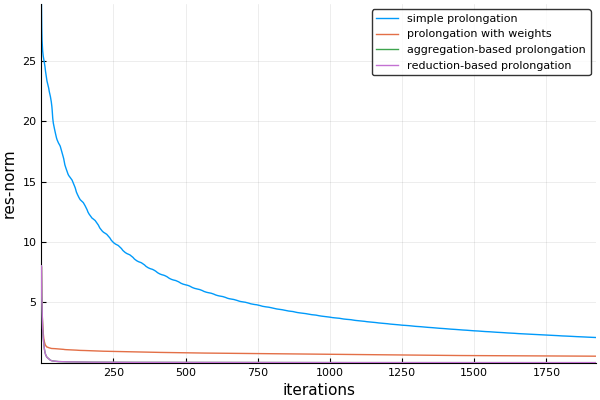

In [15]:
A = getA()
n = size(A,1)
b = ones(Float64, n,1)
# solve
@time x1, history1 = solve(A, b, prolongation1(n))
@time x2, history2 = solve(A, b, prolongation2(n))
@time x3, history3 = solve(A, b, prolongationAggregation(A))
@time x4, history4 = solve(A, b, prolongationReduction(getA()))

# plot
#gr()
pyplot()
history1data = history1.data[:resnorm]
history2data = history2.data[:resnorm]
history3data = history3.data[:resnorm]
history4data = history4.data[:resnorm]

plot(history1data, xlabel="iterations", ylabel="res-norm", label="simple prolongation")
plot!(history2data, label="prolongation with weights")
plot!(history3data, label="aggregation-based prolongation")
plot!(history4data, label="reduction-based prolongation")
#savefig("prolongations.png")